In [1]:
import pandas as pd

from AssetAllocation.datamanger import datamanger as dm
from AssetAllocation.analytics import summary
from AssetAllocation.reporting import reports as rp, plots, formatter as fmt
import matplotlib.pyplot as plt
import numpy as np
import stochMV as stMV
import seaborn as sns
from ipywidgets import interact, interact_manual

PLAN = 'IBT'

In [2]:
#get return
mv_inputs_dict = dm.get_mv_inputs_data('inputs_test.xlsx', plan=PLAN)
mv_inputs = summary.get_mv_inputs(mv_inputs_dict)
#get historical vol and correlation
ts_dict = dm.get_ts_data(plan=PLAN)
pp_inputs = summary.get_pp_inputs(mv_inputs, ts_dict)

In [3]:
plan = summary.get_plan_params(pp_inputs)

#Display plan inputs
pp_dict = plan.get_pp_dict()
@interact
def display_pp_inputs(variable=pp_dict.keys()):
    if variable == 'Corr' or variable == 'Cov':
        return plots.draw_heatmap(pp_dict[variable], half=False)
    else:
        return fmt.get_plan_styler(pp_dict[variable])

interactive(children=(Dropdown(description='variable', options=('Policy Weights', 'Asset/Liability Returns/Vol…

In [4]:
#initialize the stochastic mean variance and generate the random returns
s = stMV.stochMV(plan, 120)
s.generate_plans()

In [6]:
s.generate_resamp_corr_dict()
@interact
def display_resampled_corr(asset_liab=s.resamp_corr_dict.keys()):
    resamp_corr_fig = plots.get_resamp_corr_fig(s.resamp_corr_dict[asset_liab], asset_liab)
    resamp_corr_fig.show()

interactive(children=(Dropdown(description='asset_liab', options=('Liability', '15+ STRIPS', 'Long Corporate',…

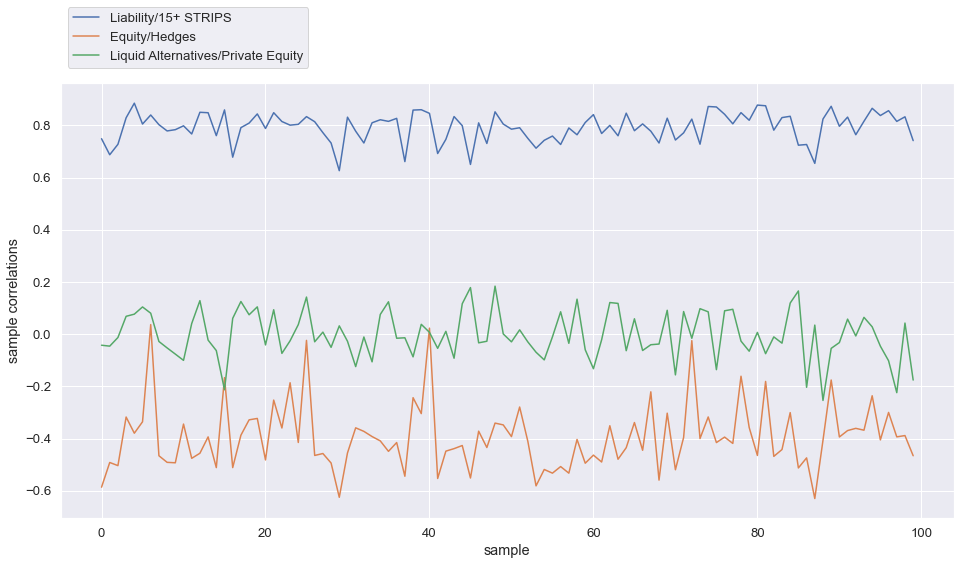

In [7]:
corr1 = pd.Series()
a1 = 'Liability'
a2 = '15+ STRIPS'
a3 = 'Equity'
a4 = 'Hedges'
a5 = 'Liquid Alternatives'
a6 = 'Private Equity'

corr2 = pd.Series()
corr3 = pd.Series()
count = 0
for plan in s.simulated_plans:
    corr1._set_value(count, plan.corr[a1][a2])
    corr2._set_value(count, plan.corr[a3][a4])
    corr3._set_value(count, plan.corr[a5][a6])
    count = count +1

plt.plot(corr1, label=a1+'/'+a2)
plt.plot(corr2, label=a3+'/'+a4)
plt.plot(corr3, label=a5+'/'+a6)
plt.xlabel('sample')
plt.ylabel('sample correlations')
plt.legend(bbox_to_anchor=(0, 1.02,1, 0.2), loc='lower left')
plt.show()


In [ ]:
#visualize the simulated returns
sns.pairplot(s.returns_df, corner=True)
# plt.savefig("sampling.jpeg")

In [ ]:
#definition of the boundaries and constraints for the optimization
bnds = dm.get_bounds(plan=PLAN)
cons = (
        # sum of Fixed Income Assets >= 50%
        {'type': 'ineq', 'fun': lambda x: np.sum(x[1:3]) - 0.5},
        #sum of all plan assets (excluding Futures and Hedges) = 2%    
        {'type': 'eq', 'fun': lambda x: np.sum(x[0:len(plan)-1]) - x[3] - .02},
        # 50% of Equity and PE >= Hedges
        {'type': 'ineq', 'fun': lambda x: (x[4]+x[6])*.5 - x[len(plan)-1]},
        # STRIPS*4 >= sum(Futures and Hedges)
        {'type': 'ineq', 'fun': lambda x: x[1]*4 - (x[3]+x[len(plan)-1])}
        )


In [ ]:
# computation of the efficient frontier for each of the simulated plan
# this takes about 5 min to run for 100 iterations, around an hour for 1000 iterations
s.generate_efficient_frontiers(bnds, cons,num_ports=25)

In [ ]:
# output the dataframe which has the average allocation
# ports_df = s.opt_ports_df
fmt.get_port_styler(s.opt_ports_df)


In [ ]:
#Asset Allocation Plot
aa_fig = plots.get_aa_fig(s.opt_ports_df)
aa_fig.show()

In [ ]:
#Plotly version of the Efficient Frontier plot
ef_fig = plots.get_ef_fig(s.opt_ports_df)
ef_fig.show()